# CNN for Sentinel Images

In [90]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import geopandas as gpd
import time

from datetime import datetime
import pickle
import random
import json

tqdm.pandas() 

rng = np.random.default_rng(342834)

In [91]:
#labels helpers and processing
def pivot_df(df, id_col, ignore_cols=None):
    if not ignore_cols:
        ignore_cols = []
    date_cols = [x for x in df.columns if x not in [id_col] + ignore_cols]
    dfs = []
    for day in date_cols:
        day_df = df[[id_col, day]].rename({day: 'snowpack'}, axis=1)
        day_df['date'] = day
        dfs.append(day_df)
    return pd.concat(dfs)

def daynum_gen(date_time):
    '''converts date time objects to filename'''
    date_time = datetime.fromisoformat(date_time)
    doy = date_time.timetuple().tm_yday
    year = date_time.year
    return str(year) + '{:03d}'.format(doy)

# Get ordered elevation training data
def add_elevation(order, modis):
    order = pd.DataFrame({'modis_idx': order, 'order': [x for x in range(len(order))]})
    order['station_id'] = order['modis_idx'].apply(lambda x: '-'.join(x.split('-')[:-1]))
    order = order.merge(elev_order).sort_values('order')
    ordered_elev = elevation[order['DEM_order'].to_list(), :, :]
    dim = ordered_elev.shape

    return np.concatenate([modis, ordered_elev.reshape(dim[0], 1, dim[1], dim[2])], axis=1)



In [92]:
## Sentinel Helpers
def y_merger(x, y):
    '''reattach y labels to sentinel'''
    y = y.rename(columns={"Unnamed: 0":"cell_id"})
    y = pivot_df(y, 'cell_id').dropna()
    y['date']=y['date'].map(daynum_gen)

    y['idx'] = y['cell_id'] + "-" + y['date']
    y = y.set_index('idx')

    x['idx'] = x['cell_id'] +\
         "-" +x['date_long'].astype(str)
    x = x.set_index('idx')

    return x.join(y['snowpack'])

#preprocessing helpers
def masker(x,y):
#     return x , y
    mask = np.all(x > -99, axis = (1,2))
    print(mask.sum(), "of", len(mask))
    
    return x[mask], y[mask]

def minmaxscaler(x):
    print("min", round(x.min(),3), "max", round(x.max(),3))
    x = (x - x.min())/(x.max() - x.min())
                   
    return x

def reshaper(ds):
    #readjust dimensions
    dim0 = ds.shape[0]
    dim1 = ds.shape[1]
    dim2 = ds.shape[2]

    return ds.reshape((dim0, 1, dim1, dim2))

In [93]:
DATA_PATH = "C:/Users/Matt/Documents/Python Scripts/SnowComp/dat/"

#@title Original data
metadata = pd.read_csv(DATA_PATH + 'ground_measures_metadata.csv')
train_inp = pd.read_csv(DATA_PATH + 'ground_measures_train_features.csv')
test_inp = pd.read_csv(DATA_PATH + 'ground_measures_test_features.csv')
train_labels = pd.read_csv(DATA_PATH + 'train_labels.csv')
grid_cells = gpd.read_file(DATA_PATH + 'grid_cells.geojson')
submission_format = gpd.read_file(DATA_PATH + 'submission_format.csv')

## Sentinel Preprocessing

In [94]:
#@title Get metadata for grid cells
states = gpd.read_file('C:/Users/Matt/Documents/Python Scripts/SnowComp/dat/states/')\
    .rename({'NAME': 'state'}, axis=1)
states = states.to_crs('EPSG:4326')

cell_metadata = gpd.sjoin(grid_cells, states[['geometry', 'state']])\
    .drop_duplicates(subset='cell_id')\
    .drop(['index_right'], axis=1)
cell_metadata['centroid'] = cell_metadata['geometry'].centroid
cell_metadata['longitude'] = cell_metadata['centroid'].x
cell_metadata['latitude'] = cell_metadata['centroid'].y
cell_metadata = cell_metadata[['cell_id', 'state', 'longitude', 'latitude']]


C:\Users\Matt\AppData\Local\Temp\ipykernel_14724\1111496563.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cell_metadata['centroid'] = cell_metadata['geometry'].centroid


In [95]:
#@title Format dfs
def get_rmse(df, actual='actual_snowpack', predicted='snowpack'):
    return ((df[actual] - df[predicted]) ** 2).mean() ** 0.5

def pivot_df(df, id_col, ignore_cols=None):
    if not ignore_cols:
        ignore_cols = []
    date_cols = [x for x in df.columns if x not in [id_col] + ignore_cols]
    dfs = []
    for day in date_cols:
        day_df = df[[id_col, day]].rename({day: 'snowpack'}, axis=1)
        day_df['date'] = day
        dfs.append(day_df)
    return pd.concat(dfs)

def get_day_of_season(doy):
    return doy + 365 - 335 if doy < 335 else doy - 335

def add_time_cols(df):
    df['date'] = pd.to_datetime(df['date'])
    df['doy'] = df['date'].dt.dayofyear
    df['dos'] = df['doy'].apply(get_day_of_season)
    df['year'] = df['date'].dt.year
    df['season'] = df['year']
    df.loc[df['doy'] < 335, 'season'] -= 1
    return df

def clean_train_test(df, id_col='station_id', metadata_df=None):
    df = pivot_df(df, id_col)
    if metadata_df is not None:
        df = df.merge(metadata_df)
    return add_time_cols(df)

def permuter(narray, df, rng= rng):
    df.reset_index(inplace= True)
    p =rng.permutation(len(narray))
    
    return narray[p], df.loc[p]

train = clean_train_test(train_inp.rename({'Unnamed: 0': 'station_id'}, axis=1),
                         metadata_df=metadata)
train2 = clean_train_test(train_labels, 'cell_id', cell_metadata).dropna()
train_full = pd.concat([train2.rename({'cell_id': 'station_id'}, axis=1).assign(datatype='labels'),
                        train.drop(['elevation_m', 'name'], axis=1).assign(datatype='ground')])

test = clean_train_test(
    test_inp.rename({'Unnamed: 0': 'station_id'}, axis=1), metadata_df=metadata)\
    .rename({'snowpack': 'actual_snowpack'}, axis=1).dropna()\
    .merge(train[['station_id', 'state']].drop_duplicates())

to_predict = clean_train_test(submission_format.drop('geometry', axis=1), 'cell_id', cell_metadata)

In [96]:
sent_path = "C:/Users/Matt/Dropbox/SnowComp/SentinelHelper/"

sentinel_trainfeat = np.load(sent_path + "sent_pp_trainfeat.npy")
sentinel_testfeat = np.load(sent_path + "sent_pp_testfeat.npy")
sentinel_ylabs = np.load(sent_path + "sent_pp_ylabs.npy")

trainfeat_meta = pd.read_csv(sent_path + "sent_trainfeat_meta.csv")
testfeat_meta = pd.read_csv(sent_path + "sent_testfeat_meta.csv")
ylabs_meta = pd.read_csv(sent_path + "sent_ylabs_meta.csv")

### Merge back in y labels, mask NAs

CHECK order not adjusted

In [97]:
sentinel_ylabs, ylabs_meta = masker(sentinel_ylabs, ylabs_meta)
sentinel_trainfeat, trainfeat_meta = masker(sentinel_trainfeat, trainfeat_meta)
sentinel_testfeat, testfeat_meta = masker(sentinel_testfeat, testfeat_meta)

sentinel_ylabs = minmaxscaler(sentinel_ylabs)
sentinel_trainfeat = minmaxscaler(sentinel_trainfeat)
sentinel_testfeat = minmaxscaler(sentinel_testfeat)

76159 of 76410
105571 of 106760
38618 of 38628
min -57.906 max 18.57
min -50.229 max 19.536
min -27.488 max 14.445


In [98]:
dataset = np.concatenate([sentinel_trainfeat, sentinel_ylabs])
train_y = pd.concat([trainfeat_meta, ylabs_meta])
train_y['date'] = pd.to_datetime(train_y['date'])
train_y = train_y.merge(train_full.rename({'station_id': 'cell_id'}, axis=1)\
                                    [['cell_id', 'snowpack', 'date']])

testfeat_meta['date'] = pd.to_datetime(testfeat_meta['date'])
sentinel_ylab_test = testfeat_meta.merge(
    test.rename({'station_id': 'cell_id', 'actual_snowpack': 'snowpack'}, axis=1)\
    [['cell_id', 'snowpack', 'date']])

In [99]:
# sentinel_testfeat, sentinel_ylab_test
del sentinel_ylabs
del ylabs_meta
del sentinel_trainfeat
del trainfeat_meta

## Define Training and Testing Sets


`dataset -> sentinel_ylabs`

In [100]:
#@title Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

## Define CNN

In [101]:
#@title Define simple CNN
# From: https://pytorch.org/tutorials/recipes/recipes/defining_a_neural_network.html
# Also used: https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html

START_D = 1
START_HW = 41

class Net(nn.Module):

    def _conv_calc(self, in_dim, pad, stride, k):
        out = int(np.floor((in_dim + 2 * pad - (k - 1) - 1) / stride + 1))
        return out

    def __init__(self, cdim1, cdim2, cdim3, kernel_sz, dropout,
                 ldim, print_dim = True):
        super(Net, self).__init__()
        
        #first layer
        self.conv1 = nn.Conv2d(START_D, cdim1, kernel_sz, 1)
        self.avgpool = nn.AvgPool2d(3, stride= 1)
        
        c1_dim = self._conv_calc(START_HW, 0, 1, kernel_sz)
        mp0_dim = self._conv_calc(c1_dim, 0, 1, 3)
        
        #second layer
        self.conv2 = nn.Conv2d(cdim1, cdim2, kernel_sz, 1)
        c2_dim = self._conv_calc(mp0_dim, 0, 1, kernel_sz)
        mp1_dim = self._conv_calc(c2_dim, 0, 1, 3)
        
        #third layer
        self.conv3_ = nn.Conv2d(cdim3, cdim3, kernel_sz, 1)
        self.conv3 = nn.Conv2d(cdim2, cdim3, kernel_sz, 1)
        c3_dim = self._conv_calc(mp1_dim, 0, 1, kernel_sz)
        c3__dim = self._conv_calc(c3_dim, 0, 1, kernel_sz)
        c3___dim = self._conv_calc(c3_dim, 0, 1, kernel_sz)
        mp2_dim = self._conv_calc(c3___dim, 0, 1, 3)
        
        #fourth layer
        print(cdim3, mp2_dim, mp2_dim)
        flattened_dim = cdim3 * mp2_dim * mp2_dim
        self.fc1 = nn.Linear(200, ldim)
        self.fc2 = nn.Linear(ldim, 1)

        #extras
        self.dropout1 = nn.Dropout2d(dropout)
        self.dropout2 = nn.Dropout2d(dropout*2)
        self.BatchNorm1 = nn.BatchNorm2d(cdim1)
        self.BatchNorm3 = nn.BatchNorm2d(cdim3)
        
        if print_dim:
            print('c1 dim:', c1_dim)
            print('mp0 dim:', mp0_dim)
            print('c2 dim:', c2_dim)
            print('mp1 dim:', mp1_dim)
            print('c3 dim:', c3_dim)
            print('c3_ dim:', c3__dim)
            print('c3__ dim:', c3___dim)
            print('mp2 dim:', mp2_dim)
            print('flattened_dim', flattened_dim)
            
        
        
    def forward(self, x):
        #first layer
        x = self.conv1(x)
        x = F.tanh(x)
        # x = F.relu(x)
        x = self.BatchNorm1(x)
        x = self.avgpool(x)
        
        #second layer
        x = self.dropout1(x)
        x = self.conv2(x)
        x = F.tanh(x)
        # x = F.relu(x)
        x = self.avgpool(x)
        
        #third layer
        x = self.dropout2(x)
        x = self.conv3(x)
        x = F.tanh(x)
        
        x = self.conv3_(x)
        x = F.tanh(x)
        
        x = self.conv3_(x)
        x = F.tanh(x)
        # x = F.relu(x)
        x = self.BatchNorm3(x)
        x = self.avgpool(x)
        
        #fourth layer
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
#         print(x.size())
        x = self.fc1(x)
        x = F.tanh(x)
        # x = F.relu(x)
        
        output = self.fc2(x)
        return output

In [102]:
#@title Helpers to get predictions and accuracy
def predict(cnn, x, as_numpy=False):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    cnn.eval()
    x = x.type(torch.FloatTensor).to(device)
    output = cnn(x)
    if as_numpy:
        output = output.flatten().cpu().detach().numpy() #detach removes gradients (bad)
        
    cnn.train()
    return output.squeeze()

def get_accuracy(cnn, x, y):
#     y = torch.from_numpy(y).to(device)
    outputs = predict(cnn, x, as_numpy = False)
    loss = ((y-outputs)**2).sum()
    return round(loss.item(), 6)

In [103]:
# #@title Setup net
# cdim1=60; cdim2=20; cdim3 =15; kernel_sz=3; dropout=0.13; ldim=40; lrate = 0.0003
# my_nn = Net(cdim1=cdim1, cdim2=cdim2,cdim3 =cdim3, kernel_sz=kernel_sz, dropout=dropout, ldim=ldim)
# optimizer = optim.Adam(my_nn.parameters(), lr=0.1)
# optimizer.zero_grad()

# # test_im = torch.from_numpy(dataset[0]).reshape(1, START_D, 21, 21)
# test_im = torch.from_numpy(dataset[0]).reshape(1, START_D, 41, 41)
# result = my_nn(test_im.type(torch.FloatTensor))
# result.shape

In [104]:
#@title Get data loaders

mini_x = np.array(dataset.reshape(dataset.shape[0], 1, 41, 41))
mini_y = np.array(train_y['snowpack'])
mini_x, mini_y = torch.Tensor(mini_x), torch.Tensor(mini_y)

test_x = np.array(sentinel_testfeat.reshape(sentinel_testfeat.shape[0], 1, 41, 41))
test_y = np.array(sentinel_ylab_test['snowpack'])
test_x, test_y = torch.Tensor(test_x), torch.Tensor(test_y)
test_dataset = TensorDataset(test_x, test_y)
test_loader = DataLoader(test_dataset, batch_size = 200)

mini_dataset = TensorDataset(mini_x, mini_y)
mini_loader = DataLoader(mini_dataset, batch_size=200)

train_rows = len(mini_x)
test_rows = len(test_x)

In [105]:
#@ title Setup net
cdim1, cdim2, cdim3, kernel_sz, dropout, ldim, lr = 32, 18, 8, 7, 0.13, 16, 1e-4
# cdim1, cdim2, cdim3, kernel_sz, dropout, ldim = 48, 18, 8, 3, 0.2, 50

my_nn = Net(cdim1=cdim1, cdim2=cdim2, cdim3=cdim3, kernel_sz=kernel_sz, dropout=dropout, ldim=ldim)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
my_nn.to(device)
optimizer = optim.Adam(my_nn.parameters(), lr=lr)#0.00005)
criterion = nn.MSELoss(reduction = 'sum')


8 11 11
c1 dim: 35
mp0 dim: 33
c2 dim: 27
mp1 dim: 25
c3 dim: 19
c3_ dim: 13
c3__ dim: 13
mp2 dim: 11
flattened_dim 968


In [106]:
#@title Run net
N_EPOCHS = 90

test_loss = []
train_loss = []
t0 = time.time()

for epoch in tqdm(range(N_EPOCHS)):
    running_loss = 0.0
    for i, data in enumerate(mini_loader, 0):
        optimizer.zero_grad()

        inputs, labels = data[0].to(device), data[1].to(device)

        outputs = my_nn(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
#         if (i + 1) % 100 == 0:
#             writer.add_scalar('Loss/train', running_loss , write_index)
#         write_index += 1

    train_loss.append(running_loss/train_rows)
#     writer.add_scalar('Acc/val', train_loss[-1], write_index)
    
    #calculate test loss.
    with torch.no_grad():        
        running_tar_loss = 0
        for data, target in test_loader:
            running_tar_loss += get_accuracy(my_nn, data, target.to(device))


        test_loss.append(running_tar_loss / test_rows)
#         writer.add_scalar('Test MSE', test_loss[-1], write_index)

    print(epoch, '/', N_EPOCHS,
          'complete, train:', round(np.sqrt(train_loss[-1]), 4),
          "test:", round(np.sqrt(test_loss[-1]), 4),
          'elapsed:', round(time.time() - t0))
    
# writer.close()
print('Finished Training')

  0%|          | 0/90 [00:00<?, ?it/s]

C:\Users\Matt\miniconda3\envs\pytorch_gp\lib\site-packages\torch\nn\functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


0 / 90 complete, train: 17.4259 test: 12.1248 elapsed: 14
1 / 90 complete, train: 16.0192 test: 11.169 elapsed: 28
2 / 90 complete, train: 15.4497 test: 10.9092 elapsed: 43
3 / 90 complete, train: 15.1285 test: 10.7236 elapsed: 57
4 / 90 complete, train: 14.8938 test: 10.6178 elapsed: 73
5 / 90 complete, train: 14.7215 test: 10.5599 elapsed: 88
6 / 90 complete, train: 14.6433 test: 10.5354 elapsed: 102
7 / 90 complete, train: 14.5467 test: 10.5319 elapsed: 116
8 / 90 complete, train: 14.5001 test: 10.5412 elapsed: 131
9 / 90 complete, train: 14.4609 test: 10.5681 elapsed: 145
10 / 90 complete, train: 14.4368 test: 10.5768 elapsed: 159
11 / 90 complete, train: 14.4219 test: 10.5966 elapsed: 173
12 / 90 complete, train: 14.4218 test: 10.6205 elapsed: 188
13 / 90 complete, train: 14.4135 test: 10.633 elapsed: 203
14 / 90 complete, train: 14.3864 test: 10.6501 elapsed: 218
15 / 90 complete, train: 14.4097 test: 10.6632 elapsed: 233
16 / 90 complete, train: 14.4 test: 10.6885 elapsed: 247
1

In [107]:
torch.cuda.empty_cache()

### Checking Accuracy

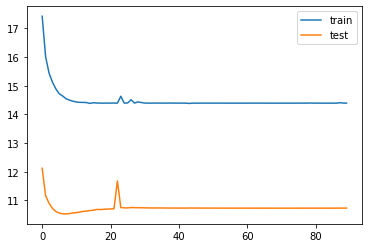

In [108]:
path = "C:/Users/Matt/Dropbox/SnowComp/RunGraphs/" 

suffix = "_" + \
    str(cdim1)+ "_" + str(cdim2)+ "_" +str(cdim3)+ "_" + str(kernel_sz)+ \
    "_" + str(dropout)+ "_" + str(ldim)+ "_" + str(epoch) +"_" + str(lrate)

plt.plot(range(epoch+1), np.sqrt(train_loss), label ="train")
plt.plot(range(epoch+1), np.sqrt(test_loss), label ="test")
plt.legend()
plt.savefig(path +"sent_converge_alldata" + suffix+ ".png")

## Save Model and Predictions

In [109]:
pred_all = True
if pred_all:
    full_x = np.concatenate((dataset.reshape(dataset.shape[0], 1, 41, 41),
               sentinel_testfeat.reshape(sentinel_testfeat.shape[0], 1, 41, 41)),
              axis= 0)

    full_y_meta = pd.concat((train_y, sentinel_ylab_test),
                           axis = 0)

    full_x, full_y_meta = permuter(full_x, full_y_meta)
    full_y = np.array(full_y_meta['snowpack'])
    
    full_x, full_y = torch.Tensor(full_x), torch.Tensor(full_y)
    full_dataset = TensorDataset(full_x, full_y)
    full_loader = DataLoader(full_dataset, batch_size=200)
    
    del dataset, sentinel_testfeat, train_y, sentinel_ylab_test

In [110]:
if pred_all:
    #@title Setup net
    my_nn = Net(cdim1=cdim1, cdim2=cdim2,cdim3 =cdim3,
                kernel_sz=kernel_sz, dropout=dropout, ldim=ldim)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    my_nn.to(device)

    optimizer = optim.Adam(my_nn.parameters(), lr=lrate)
    criterion = nn.MSELoss(reduction = 'sum')

8 11 11
c1 dim: 35
mp0 dim: 33
c2 dim: 27
mp1 dim: 25
c3 dim: 19
c3_ dim: 13
c3__ dim: 13
mp2 dim: 11
flattened_dim 968


In [111]:
if pred_all:
    train_loss = []

    #@title Run net
    for epoch in tqdm(range(int(N_EPOCHS*1.1))):
        running_loss = 0.0
        for i, data in enumerate(full_loader, 0):
            optimizer.zero_grad()
            inputs, labels = data[0].to(device), data[1].to(device)

            outputs = my_nn(inputs).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_loss.append(running_loss/train_rows)
        print(epoch, '/', N_EPOCHS,
              'complete, train:', round(np.sqrt(train_loss[-1]), 4),
              "test:", round(np.sqrt(test_loss[-1]), 4) )
        
    torch.cuda.empty_cache()

  0%|          | 0/99 [00:00<?, ?it/s]

C:\Users\Matt\miniconda3\envs\pytorch_gp\lib\site-packages\torch\nn\functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


0 / 90 complete, train: 17.4508 test: 10.7338
1 / 90 complete, train: 15.3834 test: 10.7338
2 / 90 complete, train: 15.2146 test: 10.7338
3 / 90 complete, train: 15.2052 test: 10.7338
4 / 90 complete, train: 15.2014 test: 10.7338
5 / 90 complete, train: 15.1933 test: 10.7338
6 / 90 complete, train: 15.1979 test: 10.7338
7 / 90 complete, train: 15.1916 test: 10.7338
8 / 90 complete, train: 15.1899 test: 10.7338
9 / 90 complete, train: 15.1881 test: 10.7338
10 / 90 complete, train: 15.1861 test: 10.7338
11 / 90 complete, train: 15.1628 test: 10.7338
12 / 90 complete, train: 15.1746 test: 10.7338
13 / 90 complete, train: 15.1554 test: 10.7338
14 / 90 complete, train: 15.1391 test: 10.7338
15 / 90 complete, train: 15.1177 test: 10.7338
16 / 90 complete, train: 15.0501 test: 10.7338
17 / 90 complete, train: 14.9821 test: 10.7338
18 / 90 complete, train: 14.9317 test: 10.7338
19 / 90 complete, train: 14.877 test: 10.7338
20 / 90 complete, train: 14.836 test: 10.7338
21 / 90 complete, train: 

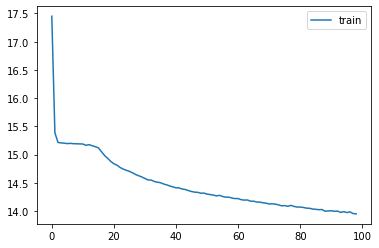

In [112]:
if pred_all:
    path = "C:/Users/Matt/Dropbox/SnowComp/RunGraphs/" 

    suffix = "_" + \
        str(cdim1)+ "_" + str(cdim2)+ "_" +str(cdim3)+ "_" + str(kernel_sz)+ \
        "_" + str(dropout)+ "_" + str(ldim)+ "_" + str(epoch) +"_" + str(lrate) 

    plt.plot(range(epoch+1), np.sqrt(train_loss), label ="train")
    plt.legend()
    plt.savefig(path +"sent" + suffix+ ".png")

In [123]:
if pred_all:
    my_nn.eval()

    torch.save(my_nn.state_dict(), path +"model_sent"+suffix)

    vals = []
    for inputs, _ in full_loader:
        with torch.no_grad():
            inputs = inputs.to(device)
            vals.append(my_nn(inputs).cpu().numpy())
    vals =  np.concatenate(vals, axis = 0)       

    path_preds = "C:/Users/Matt/Dropbox/SnowComp/preds/" 
    np.save(path_preds+"sentpreds.npy", vals)

    data_path = "C:/Users/Matt/Dropbox/SnowComp/FinalData/"
    full_y_meta.to_csv(data_path +"sent_ymeta.csv")
    
    del full_x, full_y, full_y_meta, full_dataset, full_loader, vals




In [137]:
if pred_all:
    sub1_meta = pd.read_csv(sent_path + "sent_sub1_meta.csv")
    sub2_meta = pd.read_csv(sent_path + "sent_sub2_meta.csv")
    sub_ds1 = np.load(sent_path + "sent_pp_sub1.npy")
    sub_ds2 = np.load(sent_path + "sent_pp_sub2.npy")

    sub_meta = pd.concat((sub1_meta, sub2_meta), axis = 0)
    sub_dataset = np.concatenate((sub_ds1, sub_ds2), axis = 0)
    
    sub_dataset = sub_dataset.reshape((-1, 1, 41, 41))
    del sub1_meta, sub2_meta, sub_ds1, sub_ds2

# sub_meta = np.array(sub_meta['snowpack'])

In [141]:
for images in sub_loader:
    print(images[0].shape)
    break

torch.Size([5000, 1, 41, 41])


In [142]:
if pred_all:
    #Predict and save on submission data
    vals_sub = []
    
    sub_dataset = torch.Tensor(sub_dataset)
    sub_ds = TensorDataset(sub_dataset)
    sub_loader = DataLoader(sub_ds, batch_size=5000)

    with torch.no_grad():
        for images in sub_loader:
            images = images[0].to(device)
            vals_sub.append(my_nn(images).cpu().numpy()) 

    vals_sub = np.concatenate(vals_sub, axis = 0)        
    np.save(path_preds+"sent_subpred.npy", vals_sub)

C:\Users\Matt\miniconda3\envs\pytorch_gp\lib\site-packages\torch\nn\functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
